# DRLHP 简介

[原始 DRLHP](https://github.com/HumanCompatibleAI/learning-from-human-preferences) 代码是基于 OpenAI 和 DeepMind 的 [《从人类偏好中学习的深度强化学习》](https://blog.openai.com/deep-reinforcement-learning-from-human-preferences/) 复现，由 Matthew Rahtz 完成，并经过重构以便于在加州大学伯克利分校人类兼容人工智能研究中心的研究应用中使用。

我们对代码进行重构于 {mod}`~tvm_book.drlhp`。

```{note}
[原始版本的代码库](https://github.com/mrahtz/learning-from-human-preferences)的目标是成功训练 DRLHP（Deep Reinforcement Learning from Human Preferences），使用合成和人类的偏好在 Pong、Enduro 和新颖的移动点环境中进行训练，其 API 主要设计用于这些小型重现案例。[HumanCompatibleAI DRLHP](https://github.com/HumanCompatibleAI/learning-from-human-preferences) 重构的目标包括：

* 将 API 从单一 `run.py` 文件更改为更模块化的设计，以便可以插入其他实验代码
* 添加对任意像素基础环境的支持，具有不同大小和通道数
* 允许更容易地与更广泛的最新 RL 实现集成，而不是在代码库中有特定的 A2C 实现
* 简化加载预训练策略（无论是来自 RL 还是模仿）以预热训练过程的过程，除了从头开始启动策略外

为了实现[HumanCompatibleAI DRLHP](https://github.com/HumanCompatibleAI/learning-from-human-preferences)的目标，DRLHP 的基本元素被重构为 Gym 风格的环境包装器。这个包装器：

* 管理创建子进程，用于异步奖励预测器训练和异步收集偏好对的片段
* 存储从底层环境返回的观察结果，将它们连接成片段。当片段达到指定长度时，它们会通过管道传递给负责构建片段对并请求偏好的子进程
* 可以返回底层环境的奖励或奖励预测器的奖励，该奖励预测器在整个奖励预测器训练过程中加载和更新
* 可以与任何兼容 Gym 的 RL 算法一起使用，可以将奖励预测器奖励传递给它，而无需对其进行特殊修改
```


安装依赖

```bash
conda install anaconda::swig
conda install -c conda-forge box2d-py
pip install tensorflow pyglet "gymnasium[all]>=1.0" -i https://pypi.tuna.tsinghua.edu.cn/simple
```

In [1]:
import sys
from pathlib import Path
root_dir = Path(".").resolve().parents[2]
root_dir = root_dir/"tests/gym-multigrid"
sys.path.extend([str(root_dir)])

## 创建 `CollectGame4HEnv100x100N2` 环境

In [2]:
from pathlib import Path
import imageio
from gym_multigrid.envs.collect_game import CollectGameEnv

temp_dir = Path("images")
kwargs={
    "size": 15,
    "num_balls": [5,],
    "agents_index": [1, 2, 3],  # green, purple
    "balls_index": [0,],  # red, orange, yellow
    "balls_reward": [1,],
    "respawn": False,
}
env = CollectGameEnv(**kwargs)
frames = [env.render()]
obs, info = env.reset()
while True:
    actions = [env.action_space.sample() for a in env.agents]
    obs, reward, terminated, truncated, info = env.step(actions)
    frames.append(env.render())
    if terminated or truncated:
        print(f"episode ended after {env.step_count} steps")
        print(f"agents collected {env.collected_balls} objects")
        break
temp_dir = Path(temp_dir)
(temp_dir/"animations").mkdir(parents=True, exist_ok=True)
imageio.mimsave(temp_dir/f"animations/multigrid-collect.gif", frames, duration=0.5)

episode ended after 100 steps
agents collected 3 objects


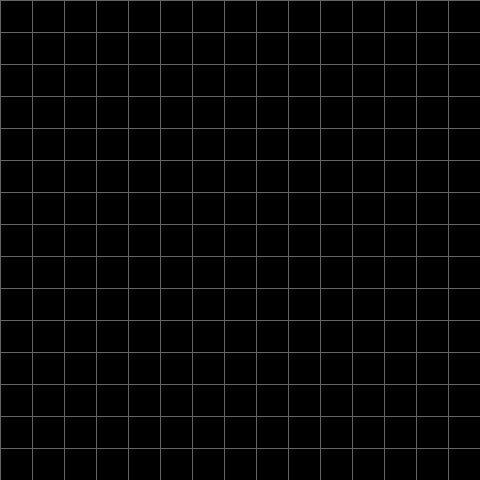

In [3]:
from IPython import display
display.Image(temp_dir/f"animations/multigrid-collect.gif")

## 使用 {class}`~drlhp.HumanPreferencesEnvWrapper`

In [4]:
from drlhp import HumanPreferencesEnvWrapper
wrapped_env = HumanPreferencesEnvWrapper(env)

2024-10-15 12:40:03.058876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:40:03.075929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 12:40:03.081261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 12:40:03.095182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 12:40:04.267623: W tensorflow/compiler/tf2

2024-10-15 12:40:06.228286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:40:06.248749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 12:40:06.255043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 12:40:06.261504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:40:06.281173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factor